In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pickle

In [48]:
from keras.models import Model
from keras import layers
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend
from sklearn.metrics import classification_report

In [49]:
train = pd.read_csv('train.csv', low_memory=False)
train_id = pd.read_csv('train.csv', low_memory=False, usecols = ['id'])
test_id  = pd.read_csv('test.csv', low_memory=False, usecols = ['id'])
train_target = pd.read_csv('train.csv', usecols = ['target'])
embedding_matrix = pd.read_csv('data_process/embedding_matrix').values

In [50]:
totaldata = pd.read_csv('data_process/totaldata.csv',low_memory=False)

In [51]:
totaldata.shape

(10876, 53)

In [52]:
f_num = totaldata.shape[1]

In [53]:
train = totaldata[totaldata['target'] != 2]
test = totaldata[totaldata['target'] == 2]

In [54]:
del totaldata['id']
del train['id']
del test['id']
del train['target']
del test['target']
del train['text']
del test['text']
del totaldata['text']

In [55]:
scaled = MinMaxScaler()

In [56]:
scaled_train = scaled.fit_transform(train)
scaled_test = scaled.fit_transform(test)

In [57]:
train_features = pd.DataFrame(scaled_train, columns= train.columns)
test_features = pd.DataFrame(scaled_test, columns= test.columns)

In [58]:
train_features.shape

(7613, 50)

In [59]:
f_num = train_features.shape[1]

In [60]:
num_words = embedding_matrix.shape[0]

In [61]:
totaldata.shape

(10876, 51)

In [62]:
embedding_matrix.shape

(19919, 100)

In [63]:
totaldata.shape

(10876, 51)

In [64]:
f_num

50

In [65]:
totaldata.columns

Index(['target', 'textsize', 'punctuation_count', 'word_mean_len',
       'haslocacion', 'keyword_t_count', 'keyword_f_count', 'keyword_metric',
       'mentions_count', 'links_count', 'label_count', 'domain_metric_mean',
       'domain_metric_std', 'domain_metric_max', 'domain_metric_min', 'PRP$',
       'NNS', 'VBP', 'DT', 'NNP', 'IN', 'NN', 'PRP', 'VBD', 'TO', 'VB', 'VBG',
       'VBN', 'JJ', 'CC', 'RB', 'VBZ', 'MD', 'EX', 'CD', 'WP', 'RP', 'NNPS',
       'JJR', 'WRB', 'JJS', 'WDT', 'RBR', 'RBS', 'FW', 'PDT', 'POS', 'UH',
       'SYM', 'WP$', ''''],
      dtype='object')

In [66]:
features_input = layers.Input(shape=(f_num,), name="features")
x = layers.Dense(1024, activation='relu')(features_input)
x = layers.Dropout(0.1)(x)
features_output = layers.Dropout(0.2)(x)

emb_input = layers.Input(shape=(None,), name="embedd")
x = layers.Embedding(num_words,100,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=100,trainable=False)(emb_input)
x = layers.SpatialDropout1D(0.08)(x)
x = layers.Conv1D(1024, 7, padding="valid", activation='relu', strides=4)(x)
x = layers.Dropout(0.1)(x)
emb_output = layers.GlobalMaxPooling1D()(x)

#x = layers.GRU(128,dropout=0.1,recurrent_dropout=0.08,return_sequences=True)(x)

x = layers.concatenate([features_output, emb_output])
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(0.12)(x)
x = layers.Dense(6,activation='relu')(x)
x = layers.Dropout(0.14)(x)
conv1d = layers.Dense(1, activation='sigmoid')(x)

model4 = Model(
    inputs=[features_input, emb_input],
    outputs=[conv1d],
)
optimzer=Adam(learning_rate=1e-5)
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimzer,
    metrics=['accuracy']
)

In [67]:
pickle_in = open("data_process/tweet_pad.pickle","rb")
tweet_pad = pickle.load(pickle_in)

In [68]:
embedd_train =tweet_pad[:train.shape[0]]
embedd_test=tweet_pad[train.shape[0]:]

In [69]:
embedd_train.shape, embedd_test.shape, train_features.shape, test_features.shape

((7613, 100), (3263, 100), (7613, 50), (3263, 50))

In [70]:
embedd_test = pd.DataFrame(embedd_test)
embedd_train = pd.DataFrame(embedd_train)

In [71]:
test = pd.concat([embedd_test,test_features],axis=1)
train = pd.concat([embedd_train,train_features],axis=1)

In [72]:
train.isna().any().any() , test.isna().any().any()

(False, False)

In [73]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=6)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [74]:
history=model4.fit(
    {"features": train.values[:,100:], "embedd": train.values[:,:100]},
    train_target.values,
    batch_size=20,
    epochs=100,
    validation_split=0.2,
    verbose=1,
    callbacks=early_stop
)

Epoch 1/100
305/305 [==============================] - 9s 28ms/step - loss: 0.6636 - accuracy: 0.6159 - val_loss: 0.5923 - val_accuracy: 0.7866
Epoch 2/100
305/305 [==============================] - 8s 28ms/step - loss: 0.5676 - accuracy: 0.7450 - val_loss: 0.5017 - val_accuracy: 0.8030
Epoch 3/100
305/305 [==============================] - 9s 29ms/step - loss: 0.5100 - accuracy: 0.7711 - val_loss: 0.4537 - val_accuracy: 0.8155
Epoch 4/100
305/305 [==============================] - 10s 32ms/step - loss: 0.4835 - accuracy: 0.7877 - val_loss: 0.4324 - val_accuracy: 0.8247
Epoch 5/100
305/305 [==============================] - 10s 33ms/step - loss: 0.4598 - accuracy: 0.8031 - val_loss: 0.4173 - val_accuracy: 0.8253
Epoch 6/100
305/305 [==============================] - 10s 32ms/step - loss: 0.4486 - accuracy: 0.8082 - val_loss: 0.4136 - val_accuracy: 0.8372
Epoch 7/100
305/305 [==============================] - 10s 34ms/step - loss: 0.4406 - accuracy: 0.8144 - val_loss: 0.4065 - val_accur

In [75]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

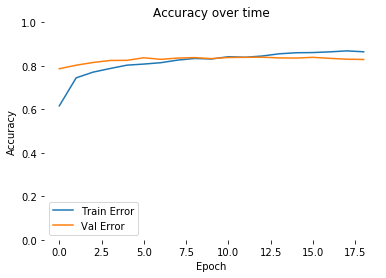

In [76]:
plot_history(history)

In [168]:
predict = model4.predict([test_features,embedd_test])
predict=np.round(predict).astype(int).reshape(3263)
submit = pd.read_csv('test.csv', usecols= ['id'])
submit['target'] = predict
submit.to_csv('submits/submit9.csv',index=False)

In [169]:
submit['target'].value_counts()

0    2031
1    1232
Name: target, dtype: int64